ERROR! Session/line number was not unique in database. History logging moved to new session 531


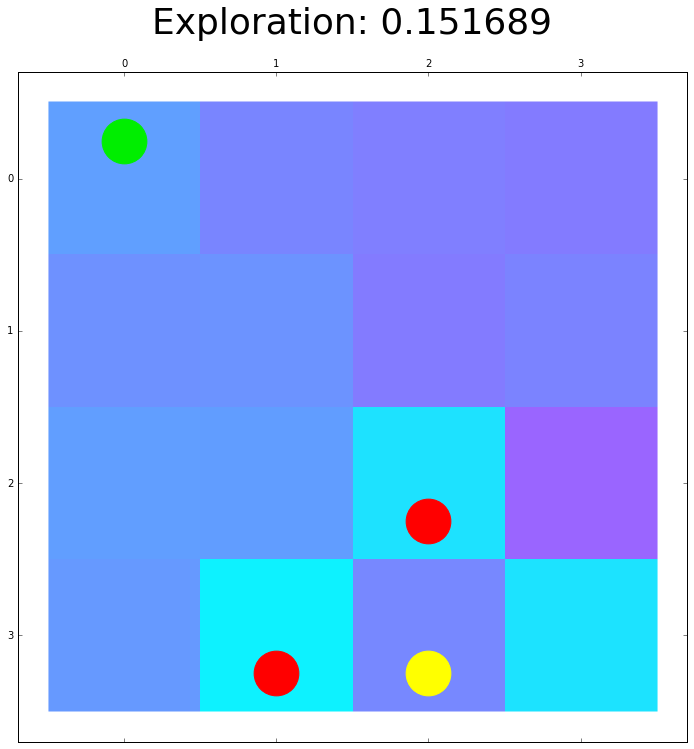

In [64]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Unsupervised Learning

Many machine learning tasks are in their core designing a model $\rho$ to approximate some unknown function $f$. Given an element from the input space, we desire that
$$ \rho(x) \approx f(x). $$

In supervised learning tasks we have some observations $f(x_i)$ which we would like to generalize in order to predict the result for other inputs, this is usually done in a regression task where we attempt to minimize the mean square error by tuning the parameters of our model $\Theta_\alpha$.
$$ \min_{\alpha} \sum_i \Big(\big|\rho(x_i) - f(x_i)\big|^2\Big) $$
Unlike many other unsupervised learning tasks, the goal of reinforcement learning is also to estimate some unknown function. However, either a useful error function to optimize is unavailable or we don't have access to meaningful estimates of the unknown function $f$ and we are unable to perform a regression task. We do however have some form of signal that we can view that tells us whether or not our model is succeeding or failing.

$e.g.$ While training a self-driving car, if we arrive safely at our destination, then we succeeded! If we crashed, however, we failed quite badly. The function we are trying to learn is the correct action to take given all sensory data involved while driving. We may not know what the absolute correct action is for all given scenarios, but we do have access to data for whether or not our current model is succeeding at the task.

$e.g.$ Playing a game of Tic-Tac-Toe. We may not have data for what the correct response is to a given board, but we do however know when we win a game and when we lose a game.

### Rewards and Punishments

We would like to set up a system of rewards and punishments for when certain events occur, $e.g.$ arriving safely at our destination, or winning a game of tic-tac-toe will give us a reward, while crashing or losing will give us a punishment. The function we would like to learn is which actions give us the highest future reward.

## Q-learning

A Q-function $Q(s\,|\,a)$, also known as an action-value function, is a function which gives the maximum future reward given a state and an action. We can think of this function as what we would like to optimize. The Bellman equation is a recursive equation which gives us a means to estimate the Q-function:
$$ Q(s\, |\, a) \sim r + \gamma\max_{a'} Q(s'\,|\,a') $$
where $r$ is the reward for taking action $a$, $\gamma$ is a discount factor which we will explain shortly, $s'$ is the state that is induced by taking action $a$ on state $s$, and $\{a'\}$ are the set of possible actions for state $s'$. The discount factor $\gamma <1$ is introduced so that we weight short-term rewards higher than long-term rewards. Usually, you solve the Bellman equation iteratively:
$$ Q(s\, |\, a)  = (1-\alpha) Q(s\, |\, a) + \alpha( r + \gamma\max_{a'} Q(s'\,|\,a')) $$
for some small $\alpha$.

## Temporal difference learning

Temporal difference learning $TD(0)$ is equivalent to learning a Q-function via solving iteratively applying the Bellman Equation. $TD(\lambda)$ was first introduced by Gerry Tesauro in 1992 to play backgammon. His program: TD-gammon famously defeated the top human players at the time. $TD(\lambda)$ attempts to estimate the Q-function for its entire history using its current estimate of the Q-function.
$$ Q(s\,|\,a) \sim (1-\lambda) \sum_{i=1}^{T-1} \lambda^{i} \Big(r^{(i-1)} + \gamma\max_{a^{(i)}} Q\big(s^{(i)}\,|\,a^{(i)}\big)\Big) + \lambda^T r^{(T)}$$
where $s^{(i+1)}$ is the state that results from using action $a^{(i)}$ on state $s^{(i)}$ and $T$ denotes a terminal state. An interesting limit of $TD(\lambda)$ is the case where $\lambda \to 1$. $TD(1)$ is also known as Monte-Carlo learning, and the Q-value update is given by
$$Q(s\,|\,a) \sim r^{(T)}, $$
$i.e.$ only the estimated final reward is used for learning.

# Gridworld!

In [68]:
import numpy as np
from numpy import random
import IPython
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [69]:
grid = np.zeros((6,7))
Q = random.random((6,7)) * 0.2 - 0.1
treasure = 4,3
traps = [(3,3),(4,2)]


grid[0,:]= -np.inf
grid[-1,:] = -np.inf
grid[:,0] = -np.inf
grid[:,-1] = -np.inf
grid[treasure] = 1
for trap in traps:
    grid[trap] = -0.5

Q[0,:]= -np.inf
Q[-1,:] = -np.inf
Q[:,0] = -np.inf
Q[:,-1] = -np.inf


print Q
print grid

ERROR! Session/line number was not unique in database. History logging moved to new session 532
[[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf -0.06265849 -0.07170678  0.03912863 -0.08372371 -0.09910142
         -inf]
 [       -inf -0.0126108  -0.00921843  0.01459889  0.05404926 -0.02579004
         -inf]
 [       -inf -0.04666937  0.04550227 -0.02327941 -0.04453384 -0.0245462
         -inf]
 [       -inf -0.05468986 -0.08940525  0.0036229  -0.01140478 -0.04072656
         -inf]
 [       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]]
[[-inf -inf -inf -inf -inf -inf -inf]
 [-inf  0.   0.   0.   0.   0.  -inf]
 [-inf  0.   0.   0.   0.   0.  -inf]
 [-inf  0.   0.  -0.5  0.   0.  -inf]
 [-inf  0.  -0.5  1.   0.   0.  -inf]
 [-inf -inf -inf -inf -inf -inf -inf]]


In [70]:
discount = 0.75
def get_moves(grid,coord):
    x,y=coord
    neigh = [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]
    return [move for move in neigh if grid[move] != - np.inf]
def move(Q,grid,coord,epsilon):
    moves = get_moves(grid,coord)
    if epsilon > random.random():
        return moves[random.randint(0, len(moves))]
    else:
        val = -np.inf
        for move in moves:
            if discount * Q[move] + grid[move] > val:
                val = discount * Q[move] + grid[move]
                cand = move
        return cand
    
def learn(Q,grid,coord,action,learning_rate):
    Q[coord] = (1-learning_rate)*Q[coord] + learning_rate *(grid[action] + discount * Q[action])
    return Q
    
        
    
    

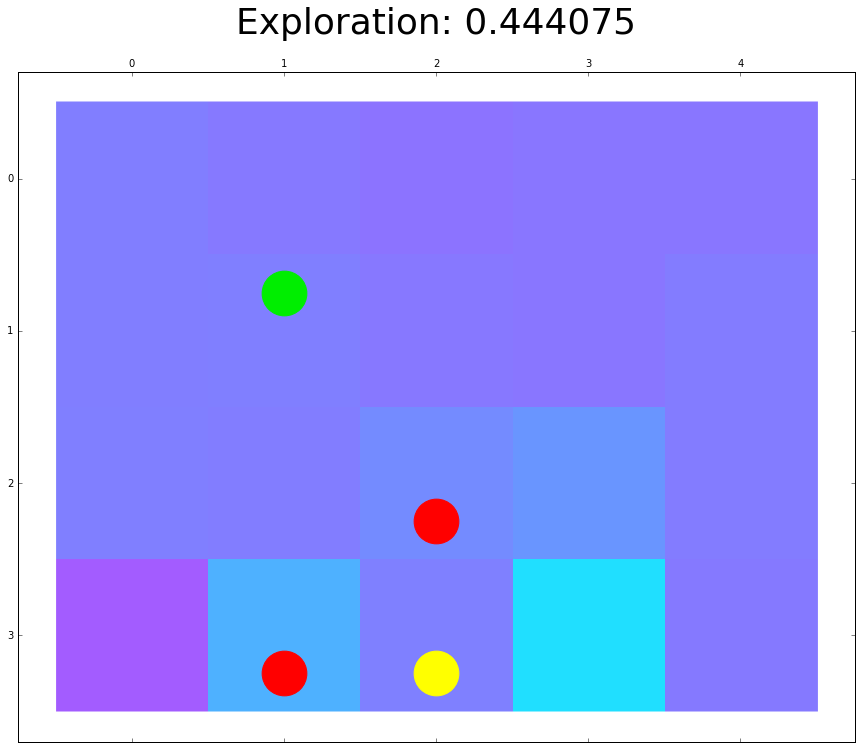

In [ ]:
start = (1,1)
coord = (1,1)
learning_rate = 0.5
discount = 0.95
epsilon = 0.9
for session in range(1000):
    action = move(Q,grid,coord,epsilon)
    Q = learn(Q,grid,coord,action,learning_rate)
    if action == treasure:
        epsilon = 0.2 + (epsilon-0.2)*0.9
        coord = treasure
        plot_coord = coord[1]-1,coord[0]-1
        plt.matshow(Q[1:-1,1:-1], vmin = -2,vmax =2,cmap = 'cool')
        plt.scatter(*plot_coord, s = 2000, color = '#00EE00')
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
        plt.close()
        coord = start
    else:
        coord = action
    
    plot_coord = coord[1]-1,coord[0]-1-0.25
    plot_treasure = treasure[1]-1,treasure[0]-1+0.25
    plot_traps = [(trap[1]-1,trap[0]-1+0.25) for trap in traps]
    plt.matshow(Q[1:-1,1:-1], vmin = -1,vmax =1,cmap = 'cool_r')
    
    plt.scatter(*plot_treasure, s = 2000, color = 'yellow')
    for plot_trap in plot_traps:
        plt.scatter(*plot_trap, s = 2000, color = 'red')
    plt.scatter(*plot_coord, s = 2000, color = '#00EE00')
    plt.title("Exploration: {:f}".format(epsilon),fontsize = 36)
    IPython.display.clear_output(wait=True)
    
    
    IPython.display.display(plt.gcf())
    plt.close()

    